In [42]:
import numpy as np

import torchvision
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch

from torchsummary import summary

import sys
import os
from collections import Counter

sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.metrics import *

import torchvision.transforms as transforms

import os
import argparse

from model import *

import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
resnet50_imagenet1 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to("cuda")
resnet50_imagenet2 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to("cuda")

In [6]:
from torchsummary import summary
print("architecture of resnet50")
summary(resnet50_imagenet1, input_size=(3, 224, 224), device="cuda")

architecture of resnet50
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNor

In [7]:
def visualize_weights(model):
    for w in model.parameters():
        w = w.data.cpu()
        break
    
    min_w = torch.min(w)
    w1 = (-1/(2 * min_w)) * w + 0.5
    
    return w1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


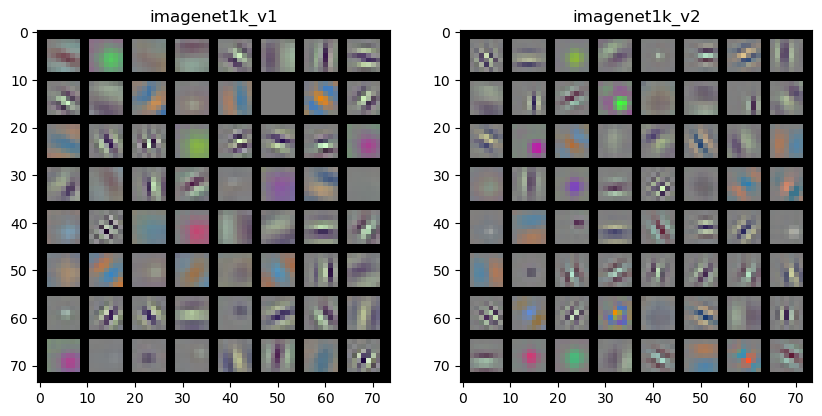

In [8]:
w1 = visualize_weights(resnet50_imagenet1)
w2 = visualize_weights(resnet50_imagenet2)


# visualize w1, w2
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torch.stack(x_grid, dim=0)
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=2)

axes, fig = plt.subplots(1, 2, figsize=(10, 10))
fig[0].imshow(x_grid.permute(1, 2, 0))
fig[0].set_title("imagenet1k_v1")

x_grid = [w2[i] for i in range(grid_size)]
x_grid = torch.stack(x_grid, dim=0)
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=2)

fig[1].imshow(x_grid.permute(1, 2, 0))
fig[1].set_title("imagenet1k_v2")

plt.show()

## Preparing Dataset

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0
start_epoch = 0

def get_mean(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])
  return [meanR, meanG, meanB]

def get_std(dataset):
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])
  return [stdR, stdG, stdB]

train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

# data augmentation 진행 X -> data augmentation 진행하면 mean, std가 달라짐
train_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(get_mean(train_dataset), get_std(train_dataset))])
test_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(get_mean(test_dataset), get_std(test_dataset))])

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# trainsform 
train_dataset.transform = train_transforms
test_dataset.transform = test_transforms

# dataloader 
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16)

Files already downloaded and verified
Files already downloaded and verified


## Resnet-50 + ImagenetV2(backbone)

In [55]:
print('==> Building model..')

net = resnet50_imagenet2
num_ftrs = net.fc.in_features   # transfer learning
net.fc = nn.Linear(num_ftrs, 10).cuda() # transfer learning
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

checkpoint = torch.load('./../checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'], strict=False)
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

==> Building model..


In [56]:
criterion = nn.CrossEntropyLoss()
label_report = []
pred_report = []

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            label_report.extend(targets.tolist())
            pred_report.extend(predicted.tolist())

    print(classification_report(label_report, pred_report, target_names=classes))

In [57]:
torch.multiprocessing.freeze_support()
test(0)

              precision    recall  f1-score   support

       plane       0.97      0.98      0.97      1000
         car       0.97      0.98      0.98      1000
        bird       0.98      0.96      0.97      1000
         cat       0.93      0.93      0.93      1000
        deer       0.96      0.98      0.97      1000
         dog       0.94      0.93      0.93      1000
        frog       0.98      0.98      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.98      0.98      0.98      1000
       truck       0.98      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Confusion Matrix

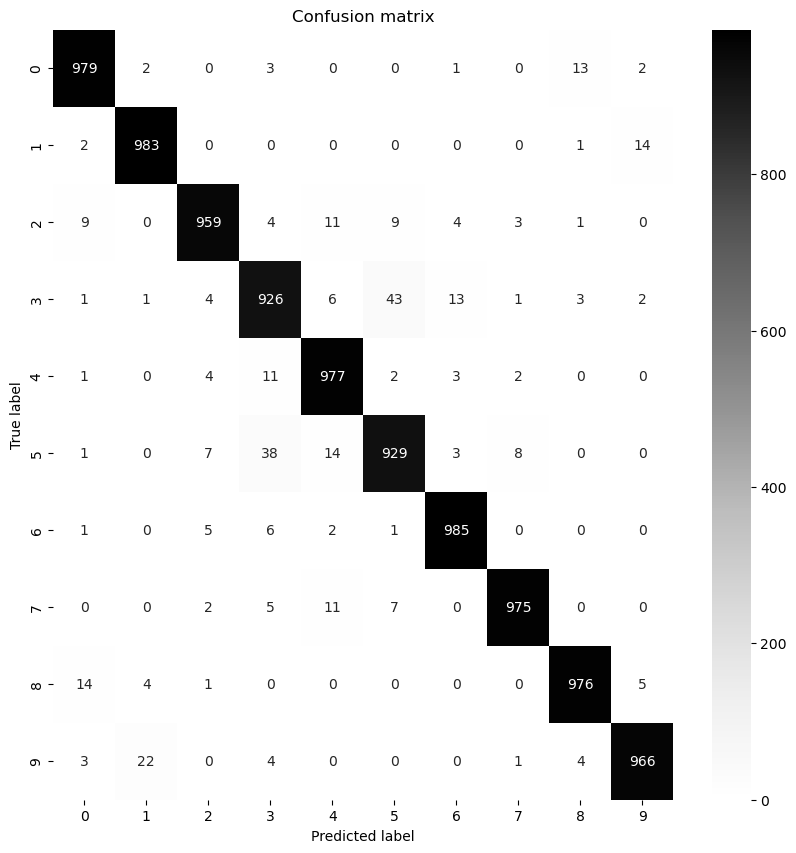

In [58]:
cm = confusion_matrix(label_report, pred_report)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()